In [245]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('/Users/nik/Dropbox/Repos/notebooks/thesisrc.py')
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft
from scipy import signal, interpolate, stats
from sklearn.preprocessing import scale
import pandas as pd
import os
import glob

plot_dir = '/Users/nik/Dropbox/data_2016/vibration_testing/plots'

In [330]:
def bandpass_filter(trace, start, stop, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    
    # filter f
    b, a = signal.butter(2, np.array([start, stop])/fny, btype='bandpass', analog=False)
    
    # apply filter
    print(trace.shape)
    filtered = signal.filtfilt(b, a, trace)
    print(filtered.shape)
    
    return filtered

def notch_filter_60(trace, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    s = 60
    r = np.array([-0.5, 0.5])
    
    # filter f
    bp_stop = r+s
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, trace)
    
    # filter 3f
    bp_stop = r+3*s
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, filtered)
    
    return filtered

def notch_filter_signal(trace, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    s = 73.19
    r = np.array([-1.0, 1.0])
    
    # filter f
    bp_stop = r+s
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, trace)
    
    # filter 2f
    bp_stop = r+2*s
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, filtered)
    
    # filter 3f
    bp_stop = r+3*s
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, filtered)
    
    return filtered

def notch_filter_144(trace, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    
    # create the 60 Hz filter
    bp_stop = np.array([120, 160])
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, trace)
    return filtered

def notch_filter_low(trace, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    
    # create the 60 Hz filter
    bp_stop = np.array([1, 30])
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, trace)
    return filtered

def notch_filter_16k(trace, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    
    # create the 16100 Hz filter
    bp_stop = np.array([15950, 16050.0])
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, trace)
    return filtered

def wav_to_df(filename, channel='left', filter_signal=False):
    """ return arrays of time and sound amplitude """
    
    sampFreq, snd = wavfile.read(filename)

    # snd = snd / (2.**15) #convert sound array to float pt. values
    
    if channel == 'left':
        channel = 0
    elif channel == 'right':
        channel = 1
    else:
        raise ValueError('Pick a channel!')
    try:
        snd = snd[:,channel]
    except IndexError:
        snd = snd
    
    N = len(snd)
    T = np.arange(0,N)/sampFreq
    
    filt = notch_filter_60(snd)
    filt = notch_filter_16k(filt)
    if filter_signal:
        filt = notch_filter_signal(filt)
    
    return pd.DataFrame({'T':T, 'A':snd, 'A_filt':filt})

def get_ft(trace, fs=44100):

    n = len(trace)
    dt = 1/fs # assume everything was taken at 44100 Hz

    xf = np.linspace(0.0, 1.0/(2.0*dt), n/2)

    yft = fft(trace)
    yft = yft*np.conjugate(yft)*(dt/n) # mV^2/Hz
    yft = np.sqrt(np.real(yft[:int(n/2)])) # mV/sqrt(Hz)
    
    return xf, yft

def window_fft(trace, width, window='hamming', overlap=0.5):
    """ average fft over windows of length width (in seconds) """
    fs = 44100.0
    pts = int(np.ceil(width*fs))
    step = int(pts*(1-overlap))
    starts = np.arange(0, len(trace)-pts, step)
    
    if starts[-1]+pts > len(trace)-1:
        starts = starts[:-1]

    if window=='square':
        window = np.ones(pts)
    elif window=='hamming':
        window = np.hamming(pts)
    elif window=='hanning':
        window = np.hanning(pts)
    else:
        raise ValueError('Pick a window!')

    fftall = np.zeros((len(starts),pts/2))
    
#     print(len(trace), pts, step)
    for i,start in enumerate(starts):
        sample = trace[start:start+pts]
#         print('sample {0}: {1} to {2}'.format(i, start, start+pts))
        xf, sample_fft = get_ft(sample*window)
        fftall[i,:] = sample_fft*2
    
    return xf, fftall

def integrate_noise(x, trace, f0, f1):
    x = x[1:]
    trace = trace[1:]
    idx0 = np.abs(x-f0).argmin()
    idx1 = np.abs(x-f1).argmin()
    dx = x[2]-x[1]
    return np.sqrt(np.trapz(trace[idx0:idx1]**2, x=None, dx = dx))

def all_integrated_noise(x, trace, f0, f1):
    dx = x[2]-x[1] # differential element
    idx0 = np.abs(x-f0).argmin() # starting index
    idx1 = np.abs(x-f1).argmin() # ending index
    n = idx1-idx0
    integrated = np.zeros(n-1)
    xout = np.zeros(n-1)
    s = 0
    for i in range(n-1):
        t = dx*max(trace[idx0+i]**2, trace[idx0+i+1]**2) \
                - 0.5*dx*abs(trace[idx0+i]**2 - trace[idx0+i+1]**2)
        s+=t
        integrated[i] = np.sqrt(s)
        xout[i] = x[idx0+i]+dx/2
    return xout, integrated

def window_rms(df, width, window='hanning', overlap=0.5):
    """ average fft over windows of length width (in seconds) """
    fs = 44100.0
    pts = int(np.ceil(width*fs))
    step = int(pts*(1-overlap))
    starts = np.arange(0, len(df)-pts, step)
    
    if starts[-1]+pts > len(df)-1:
        starts = starts[:-1]

    if window=='square':
        w = np.ones(pts)
        a = 1.0
    elif window=='hamming':
        w = np.hamming(pts)
        a = 1.5
    elif window=='hanning':
        w = np.hanning(pts)
        a = 2.0
    else:
        raise ValueError('Pick a window!')

    rms = np.zeros(len(starts))
    x = np.zeros(len(starts))
    
    for i,start in enumerate(starts):
        sample = df.iloc[start:start+pts,:]
        x[i] = sample['T'].mean()
        v = sample['A_filt']
        rms[i] = np.sqrt(np.mean(np.square(v*w)))
    
    return x, a*rms

In [317]:
# https://gist.githubusercontent.com/sixtenbe/1178136/raw/a222940a8f758705877296a71c4e353d50dedbaf/peakdetect.py

import numpy as np
from math import pi, log


def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError('Input vectors y_axis and x_axis must have same length')
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis
    
    
def peakdetect(y_axis, x_axis = None, lookahead = 300, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maximas and minmias in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maximas and minimas respectively
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- (optional) A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the postion of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    lookahead -- (optional) distance to look ahead from a peak candidate to
        determine if it is the actual peak (default: 200) 
        '(sample / period) / f' where '4 >= f >= 1.25' might be a good value
    delta -- (optional) this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            delta function causes a 20% decrease in speed, when omitted
            Correctly used it can double the speed of the function
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        
    return np.array(max_peaks), np.array(min_peaks)
    
    
def peakdetect_zero_crossing(y_axis, x_axis = None, window = 11):
    """
    Function for detecting local maximas and minmias in a signal.
    Discovers peaks by dividing the signal into bins and retrieving the
    maximum and minimum value of each the even and odd bins respectively.
    Division into bins is performed by smoothing the curve and finding the
    zero crossings.
    
    Suitable for repeatable signals, where some noise is tolerated. Excecutes
    faster than 'peakdetect', although this function will break if the offset
    of the signal is too large. It should also be noted that the first and
    last peak will probably not be found, as this function only can find peaks
    between the first and last zero crossing.
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- (optional) A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the postion of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    window -- the dimension of the smoothing window; should be an odd integer
        (default: 11)
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    
    zero_indices = zero_crossings(y_axis, window = window)
    period_lengths = np.diff(zero_indices)
            
    bins_y = [y_axis[index:index + diff] for index, diff in 
        zip(zero_indices, period_lengths)]
    bins_x = [x_axis[index:index + diff] for index, diff in 
        zip(zero_indices, period_lengths)]
        
    even_bins_y = bins_y[::2]
    odd_bins_y = bins_y[1::2]
    even_bins_x = bins_x[::2]
    odd_bins_x = bins_x[1::2]
    hi_peaks_x = []
    lo_peaks_x = []
    
    #check if even bin contains maxima
    if abs(even_bins_y[0].max()) > abs(even_bins_y[0].min()):
        hi_peaks = [bin.max() for bin in even_bins_y]
        lo_peaks = [bin.min() for bin in odd_bins_y]
        # get x values for peak
        for bin_x, bin_y, peak in zip(even_bins_x, even_bins_y, hi_peaks):
            hi_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
        for bin_x, bin_y, peak in zip(odd_bins_x, odd_bins_y, lo_peaks):
            lo_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
    else:
        hi_peaks = [bin.max() for bin in odd_bins_y]
        lo_peaks = [bin.min() for bin in even_bins_y]
        # get x values for peak
        for bin_x, bin_y, peak in zip(odd_bins_x, odd_bins_y, hi_peaks):
            hi_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
        for bin_x, bin_y, peak in zip(even_bins_x, even_bins_y, lo_peaks):
            lo_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
    
    max_peaks = [[x, y] for x,y in zip(hi_peaks_x, hi_peaks)]
    min_peaks = [[x, y] for x,y in zip(lo_peaks_x, lo_peaks)]
    
    return [max_peaks, min_peaks]
        
    
def _smooth(x, window_len=11, window='hanning'):
    """
    smooth the data using a window of the requested size.
    
    This method is based on the convolution of a scaled window on the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd 
            integer
        window: the type of window from 'flat', 'hanning', 'hamming', 
            'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t = linspace(-2,2,0.1)
    x = sin(t)+randn(len(t))*0.1
    y = _smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, 
    numpy.convolve, scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if a list instead of
    a string   
    """
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    
    if window_len<3:
        return x
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError,
            "Window is not one of '{0}', '{1}', '{2}', '{3}', '{4}'".format(
            *('flat', 'hanning', 'hamming', 'bartlett', 'blackman')))
    
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.' + window + '(window_len)')

    y = np.convolve(w / w.sum(), s, mode = 'valid')
    return y
    
    
def zero_crossings(y_axis, window = 11):
    """
    Algorithm to find zero crossings. Smoothens the curve and finds the
    zero-crossings by looking for a sign change.
    
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find zero-crossings
    window -- the dimension of the smoothing window; should be an odd integer
        (default: 11)
    
    return -- the index for each zero-crossing
    """
    # smooth the curve
    length = len(y_axis)
    x_axis = np.asarray(range(length), int)
    
    # discard tail of smoothed signal
    y_axis = _smooth(y_axis, window)[:length]
    zero_crossings = np.where(np.diff(np.sign(y_axis)))[0]
    indices = [x_axis[index] for index in zero_crossings]
    
    # check if zero-crossings are valid
    diff = np.diff(indices)
    if diff.std() / diff.mean() > 0.2:
        print(diff.std() / diff.mean())
        print (np.diff(indices))
        raise(ValueError, 
            "False zero-crossings found, indicates problem {0} or {1}".format(
            "with smoothing window", "problem with offset"))
    # check if any zero crossings were found
    if len(zero_crossings) < 1:
        raise(ValueError, "No zero crossings found")
    
    return indices 
    # used this to test the fft function's sensitivity to spectral leakage
    #return indices + np.asarray(30 * np.random.randn(len(indices)), int)

# Microphone Data

Going to make plots of just one of these data sets since they seem to be pretty much identical. This particular data set was taken near the balast, but I will present it as a general microphone result.

In [67]:
os.chdir('/Users/nik/Dropbox/data_2016/vibration_testing/microphone_data/')

In [68]:
datasets = [('balast_unfiltered_pt_off.wav', 'balast_unfiltered.wav'),
            ('control_rack_unfiltered_pt_off.wav', 'control_rack_unfiltered.wav'),
            ('pt_top_unfiltered_pt_off.wav', 'pt_top_unfiltered.wav'),
            ('rotary_valve_unfiltered_pt_off.wav', 'rotary_valve_unfiltered.wav')]


labels = ['Balast', 'AC Meas Rack', 'PT Top', 'Rotary Valve']

for i, names in enumerate(datasets):
    print(i, names, labels[i])

0 ('balast_unfiltered_pt_off.wav', 'balast_unfiltered.wav') Balast
1 ('control_rack_unfiltered_pt_off.wav', 'control_rack_unfiltered.wav') AC Meas Rack
2 ('pt_top_unfiltered_pt_off.wav', 'pt_top_unfiltered.wav') PT Top
3 ('rotary_valve_unfiltered_pt_off.wav', 'rotary_valve_unfiltered.wav') Rotary Valve


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


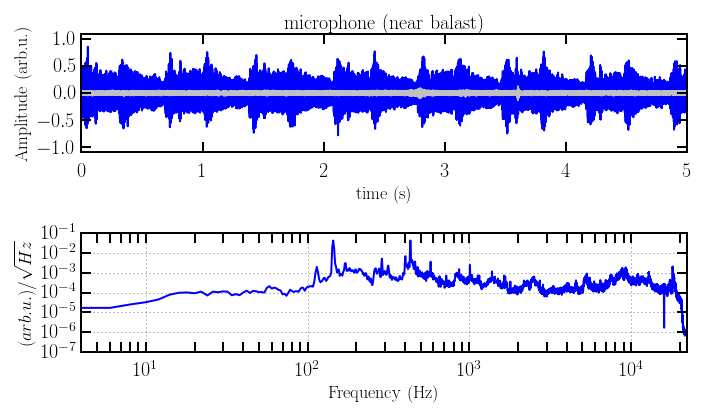

In [77]:
file_signal = 'rotary_valve_unfiltered.wav'
file_back = 'rotary_valve_unfiltered_pt_off.wav'

fs = 44100.0 # Hz

df_signal = wav_to_df(file_signal, channel='right')
df_background = wav_to_df(file_back, channel='right')

fig, ax = plt.subplots(2,1, figsize=(10,6))

t = df_signal['T']
ax[0].plot(t, 10*df_signal['A_filt']/(2.0**15), color = 'blue', lw=2)
ax[0].plot(t, 10*df_background['A_filt']/(2.0**15), color = 'silver', lw=2)
ax[0].set_ylabel('Amplitude (arb.u.)')
ax[0].set_xlabel('time (s)')
ax[0].set_xlim(0,5)
ax[0].set_ylim(-1.1, 1.1)

win = 0.5
xs, ffts = window_fft(10*df_signal['A_filt']/2.0**15, win, overlap=0.5)
signal_avg = np.mean(ffts, axis=0)

ax[1].plot(xs, signal_avg, color='blue', lw=2)
ax[1].grid()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(xs[2],22.05e3)
ax[1].set_ylim(1e-7, 1e-1)
ax[1].tick_params(axis='y',which='minor',left='off', right='off')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('$(arb.u.)/\sqrt{Hz}$')

ax[0].set_title('microphone (near balast)')
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'microphone_near_balast.png'), dpi=300)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


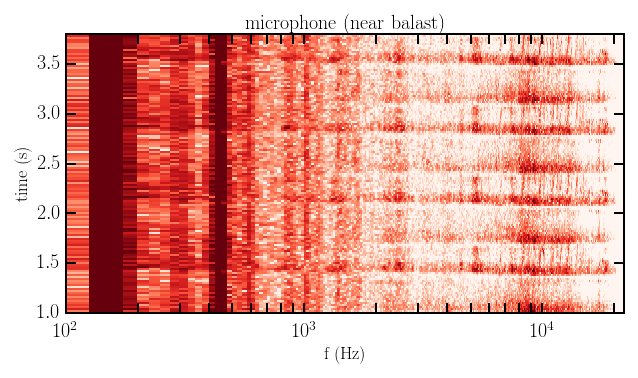

In [80]:
fs = 44100.0 # Hz
win = 0.04

# load wave and notch filtered data
df = wav_to_df(file_signal, channel='right')

xs, ffts = window_fft(df['A_filt']/2.0**15, win, overlap=0.5)
ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
dt = 1/fs
n = ffts.shape[1]
ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBV

fig, ax = plt.subplots(1,1, figsize = (10,5))

pc = ax.pcolormesh(xs, ys, ffts, cmap=plt.cm.Reds, vmin=-30, vmax=10)
ax.set_xscale('log')
ax.set_xlim(100, xs[-1])
ax.set_ylim(1,1+2.8)
ax.set_xlabel('f (Hz)')
ax.set_ylabel('time (s)')
# cb = fig.colorbar(pc)
# cb.set_label('dB')
ax.set_title('microphone (near balast)')

In the first figure, ignoring multiples of 60Hz, we see peaks at 144Hz (and its first few harmonics). At higher frequencies, the strongest peaks are at 9.2kHz and what looks like its first harmonic.

In the second image, we see broadband noise at the start of each rotary valve cycle, every 0.7s. Within each cycle is a second pulse of higher frequency noise, specifically a peak around 9kHz. At lower frequencies, the 144Hz (and its third harmonic) dominate. We also note the peaks around 850Hz and 5.2kHz, with an unknow origin, that repeats at the beginning of each cycle.

In [85]:
# time trace + averaged FFT

fs = 44100.0 # Hz
win = 0.5 # second

for i, f in enumerate(datasets):

    print(f)
    df_signal = wav_to_df(f[1], channel='left')
    df_background = wav_to_df(f[0], channel='left')

    fig, ax = plt.subplots(2,1, figsize=(10,6))

    t = df_signal['T']
    ax[0].plot(t, 10*df_signal['A_filt']/(2**15), color = 'blue', lw=2)
    ax[0].plot(t, 10*df_background['A_filt']/(2**15), color = 'silver', lw=2)
    ax[0].set_ylabel('Amplitude (arb.u.)')
    ax[0].set_xlabel('time (s)')
    ax[0].set_xlim(0,5)
    ax[0].set_ylim(-1.1, 1.1)

    xs, ffts = window_fft(10*df_signal['A_filt']/(2**15), win, overlap=0.5)
    signal_avg = np.mean(ffts, axis=0)

    ax[1].plot(xs, signal_avg, color='blue', lw=2)
    ax[1].grid()
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(xs[2],xs[-1])
    ax[1].set_ylim(1e-7, 1e-1)
    ax[1].tick_params(axis='y',which='minor',left='off', right='off')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('$mV/\sqrt{Hz}$')
    
    title = '({0:d}) {1}'.format(i, labels[i])
    ax[0].set_title(title)
    
    output = os.path.join(plot_dir,'microphone/{0}_single-fft'.format(labels[i].replace(' ', '_')))
    fig.tight_layout()
    fig.savefig(output, dpi=300)
    plt.close()

('balast_unfiltered_pt_off.wav', 'balast_unfiltered.wav')
('control_rack_unfiltered_pt_off.wav', 'control_rack_unfiltered.wav')
('pt_top_unfiltered_pt_off.wav', 'pt_top_unfiltered.wav')
('rotary_valve_unfiltered_pt_off.wav', 'rotary_valve_unfiltered.wav')


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [87]:
# plot FFTs as a function of time with fast and slow windows
# in these plots I'd like a low frequency and high frequency measurement on the left and right

fs = 44100.0 # Hz
win = 0.04 # second

for i, names in enumerate(datasets):
    df = wav_to_df(names[1], channel='left')

    xs, ffts = window_fft(df['A_filt']/2**15, win, overlap=0.5)
    ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
    dt = 1/fs
    n = ffts.shape[1]
    ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBV

    fig, ax = plt.subplots(1,1, figsize = (10,5))

    pc = ax.pcolormesh(xs, ys, ffts, cmap=plt.cm.Reds, vmin=-50, vmax=5)
    ax.set_xscale('log')
    ax.set_xlim(100, xs[-1])
    ax.set_ylim(2,2+2.8)
    ax.set_xlabel('f (Hz)')
    ax.set_ylabel('time (s)')
#     cb = fig.colorbar(pc)
#     cb.set_label('dBV')

    title = '({0:d}) {1}'.format(i, labels[i])
    ax.set_title(title)
    
    output = os.path.join(plot_dir,'microphone/{0}_time-fft'.format(labels[i].replace(' ', '_')))
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [363]:
# RMS noise from different frequency ranges

fs = 44100.0 # Hz
u_to_V = 0.0243 # mV
gain = 100
win = 0.5 # second

lows = []
mids = []
highs = []
for i, f in enumerate(datasets):

    df_signal = wav_to_df(datasets[i][1], channel='right')

    xs, ffts = window_fft(df_signal['A_filt']*u_to_V/gain, win, overlap=0.5)
    signal_avg = np.mean(ffts, axis=0)

    lows.append(integrate_noise(xs, signal_avg, 0, 200))
    mids.append(integrate_noise(xs, signal_avg, 200, 1200))
    highs.append(integrate_noise(xs, signal_avg, 1200, 23000))

N = len(datasets)
x = np.arange(0,N)
data = [lows, mids, highs]
colors = [plt.cm.Blues(np.linspace(0.2,1,N)), 
          plt.cm.Purples(np.linspace(0.2,1,N)), 
          plt.cm.Reds(np.linspace(0.2,1,N))]

fig, ax = plt.subplots(1,3, figsize = (15,5))

for i in range(3):
    barlist=ax[i].bar(x, data[i])
    for j in range(len(barlist)):
        barlist[j].set_color(colors[i][j])
    ax[i].set_xticks(x+0.5)
    ax[i].set_xticklabels(labels, rotation=60, ha='right')
    ax[i].grid()
    
ax[0].set_ylabel('V_RMS (mV)')
ax[0].set_title('0 - 200 Hz')
ax[1].set_title('200 - 1200 Hz')
ax[2].set_title('1.2 - 22.05 kHz')

output = os.path.join(plot_dir,'microphone/v-rms_l-m-h.png')
fig.tight_layout()
fig.savefig(output, dpi=300)
plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:84: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [361]:
# fs = 44100.0 # Hz
# win = 1

# for i, f in enumerate(datasets):

#     # import data
#     df_signal = wav_to_df(f[1], channel='right')
#     xs, ffts = window_fft(df_signal['A_filt']/2.0**15, win, overlap=0.5)
#     xs = xs[1:]
#     ffts = ffts[:,1:]

#     # resample data with log10 scaling
#     dx = (xs[-1]-xs[0]) / (xs.size-1)
#     xnew = 10**np.arange(np.log10(xs[1]), np.log10(xs[-1]), np.log10(dx))
#     fft10 = np.zeros((len(ffts),len(xnew)))
#     for j in range(len(ffts)):
#         f = interpolate.interp1d(xs, ffts[j,:])
#         fft10[j,:] = f(xnew)

#     fft10avg = np.mean(fft10, axis=0)
#     xnew = _smooth(xnew, window_len=2001, window='hanning')
#     fft10avg = _smooth(fft10avg, window_len=2001, window='hanning')
#     peak_max, peak_min = peakdetect(np.log10(fft10avg), x_axis=xnew, lookahead=5000, delta=0.2)

#     fig, ax = plt.subplots(1,1, figsize=(10,5))
#     ax1 = ax.twinx() # use this to plot PSD behind peak colors

#     M = len(peak_max)
#     colors = plt.cm.rainbow(np.linspace(0,1,M))
#     for j in range(M):
#         ax1.vlines(x=peak_max[j,0], ymin=0, ymax=1.0, linewidths = 2, color=colors[j])

#     ax.plot(xnew, fft10avg, color='b')
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(xnew[0],xnew[-1])
    
#     title = '({0:d}) {1} -- PT ON/OFF'.format(i, labels[i])
#     ax.set_title(title)
    
#     output = os.path.join(plot_dir,'microphone/{0}_peak-finding'.format(labels[i].replace(' ', '_'), onoff[i]))
#     fig.savefig(output, dpi=300)
#     plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:84: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Piezo dataset 1

This dataset was taken with the piezo sensor clamped firmly to the mixing chamber in vacuum. 

In [226]:
os.chdir('/Users/nik/Dropbox/data_2016/vibration_testing/piezo_dataset_1/')

In [227]:
# Load wave files and save again with the right channel duplicated to the left so it is easier to listen to.

filelist = glob.glob('*.wav')

for f in filelist:
    sampFreq, snd = wavfile.read(f)
    snd[:,0] = snd[:,1]
    if f.endswith('_stereo.wav'):
        continue
    if not os.path.isfile(f[:-4]+'_stereo.wav'):
        wavfile.write(f[:-4]+'_stereo.wav', sampFreq, snd)

Create a list of files, locations, and parameters

In [228]:
datasets = ['cryo_mc_ptoff_son_stereo.wav', 
            'cryo_mc_pton_soff_stereo.wav', 
            'cryo_mc_ptoff_soff_stereo.wav', 
            'cryo_mc_pton_soff_rvup_stereo.wav', 
            'cryo_mc_pton_soff_rvup-foam_stereo.wav', 
            'cryo_mc_pton_soff_balastup-foam_stereo.wav', 
            'cryo_mc_pton_soff_move-cables_stereo.wav', 
            'cryo_mc_pton_soff_lsout_stereo.wav',
            'cryo_mc_ptoff_soff_cson_stereo.wav',
            'cryo_mc_ptoff_soff_cson_ton_stereo.wav', 
            'cryo_mc_ptoff_440Hz_stereo.wav',
            'cryo_mc_ptoff_liquefieroff_stereo.wav',
            'cryo_mc_ptoff_liquefieron_stereo.wav'
            ]


labels = ['Scroll ON', 
         'PT ON', 
         'Background', 
         'RV UP, PT ON', 
         'RV UP+foam, PT ON', 
         'Balast UP+foam, PT ON', 
         'Move Cables, PT ON', 
         'LS OUT, PT ON', 
         'CS ON', 
         'CS ON, Turbo ON', 
         '440Hz Sound',
         'Liquifier OFF', 
         'Liquifier ON']

for i, names in enumerate(datasets):
    print(i, names, labels[i])

0 cryo_mc_ptoff_son_stereo.wav Scroll ON
1 cryo_mc_pton_soff_stereo.wav PT ON
2 cryo_mc_ptoff_soff_stereo.wav Background
3 cryo_mc_pton_soff_rvup_stereo.wav RV UP, PT ON
4 cryo_mc_pton_soff_rvup-foam_stereo.wav RV UP+foam, PT ON
5 cryo_mc_pton_soff_balastup-foam_stereo.wav Balast UP+foam, PT ON
6 cryo_mc_pton_soff_move-cables_stereo.wav Move Cables, PT ON
7 cryo_mc_pton_soff_lsout_stereo.wav LS OUT, PT ON
8 cryo_mc_ptoff_soff_cson_stereo.wav CS ON
9 cryo_mc_ptoff_soff_cson_ton_stereo.wav CS ON, Turbo ON
10 cryo_mc_ptoff_440Hz_stereo.wav 440Hz Sound
11 cryo_mc_ptoff_liquefieroff_stereo.wav Liquifier OFF
12 cryo_mc_ptoff_liquefieron_stereo.wav Liquifier ON


Check out the standard setup with no modifications, piezo on the mixing chamber, pulse tube on/off, everything else off on the BF system.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


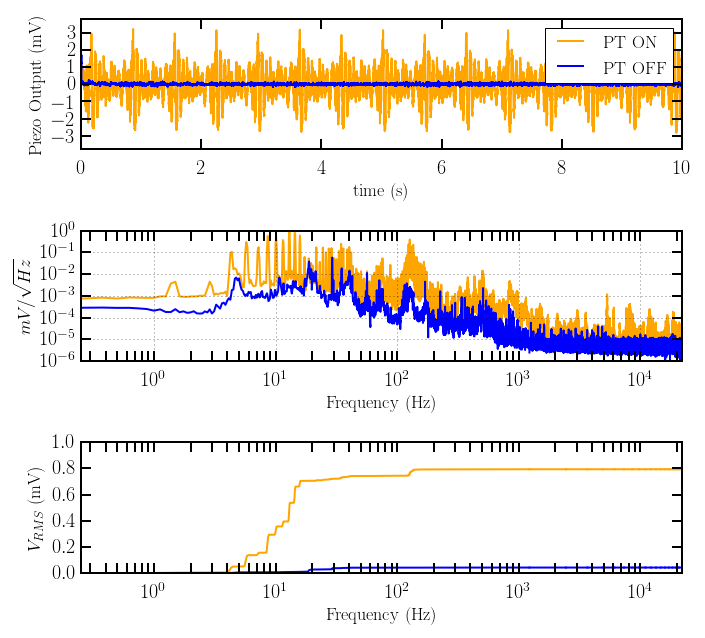

In [233]:
fs = 44100.0 # Hz
u_to_V = 0.0243 # mV
gain = 100
win = 8

df_signal = wav_to_df(datasets[1], channel='right')
df_background = wav_to_df(datasets[2], channel='right')

fig, ax = plt.subplots(3,1, figsize=(10,9))

t = df_signal['T']
ax[0].plot(t, df_signal['A_filt']*u_to_V/gain, color = 'orange', label='PT ON', lw=2)
ax[0].plot(t, df_background['A_filt']*u_to_V/gain, color = 'blue', label = 'PT OFF', lw=2)
ax[0].set_ylabel('Piezo Output (mV)')
ax[0].set_xlabel('time (s)')
ax[0].set_xlim(0,10)
ax[0].set_ylim(-3.8, 3.8)
ax[0].legend()

xs, ffts = window_fft(df_signal['A_filt']*u_to_V/gain, win, overlap=0.5)
signal_avg = np.mean(ffts, axis=0)

xs, ffts = window_fft(df_background['A_filt']*u_to_V/gain, win, overlap=0.5)
back_avg = np.mean(ffts, axis=0)

ax[1].plot(xs, signal_avg, color='orange', lw=2)
ax[1].plot(xs, back_avg, color='blue', lw=2)
ax[1].grid()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(xs[2],xs[-1])
ax[1].set_ylim(1e-6, 1)
ax[1].tick_params(axis='y',which='minor',left='off', right='off')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('$mV/\sqrt{Hz}$')

ibx, ibn = all_integrated_noise(xs, back_avg, 1, xs[-1])
isx, isn = all_integrated_noise(xs, signal_avg, 1, xs[-1])
ax[2].plot(ibx, ibn, lw=2, color = 'blue')
ax[2].plot(isx, isn, lw=2, color='orange')
ax[2].set_xscale('log')
ax[2].set_xlim(xs[2],xs[-1])
ax[2].set_ylim(0,1.0)
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('$V_{RMS}$ (mV)')

fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'piezo1/normal_conditions_single-fft.png'), dpi=300)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


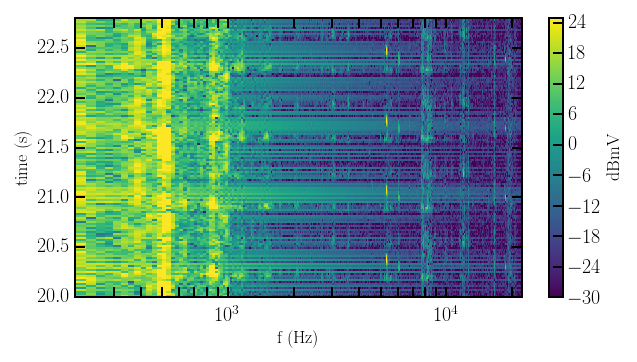

In [144]:
fs = 44100.0 # Hz
u_to_V = 0.0243 # mV
gain = 100
win = 0.04

df = wav_to_df(datasets[1], channel='right')

xs, ffts = window_fft(df['A_filt']*u_to_V/gain, win, overlap=0.5)
ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
dt = 1/fs
n = ffts.shape[1]
ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBV

fig, ax = plt.subplots(1,1, figsize = (10,5))

pc = ax.pcolormesh(xs, ys, ffts, cmap=plt.cm.viridis, vmin=-30, vmax=25)
ax.set_xscale('log')
ax.set_xlim(200, xs[-1])
ax.set_ylim(20,20+2.8)
ax.set_xlabel('f (Hz)')
ax.set_ylabel('time (s)')
cb = fig.colorbar(pc)
cb.set_label('dBmV')
# ax.set_title('Mixing Chamber -- PT ON')
fig.savefig(os.path.join(plot_dir, 'piezo1/normal_conditions_time-fft.png'), dpi=300)

Loop through all data and save plots similar to the two above.

In [11]:
# time trace + averaged FFT

fs = 44100.0 # Hz
u_to_V = 0.0243 # mV
gain = 100
win = 5 # second

for i, f in enumerate(datasets):

    df_signal = wav_to_df(datasets[i], channel='right')

    fig, ax = plt.subplots(2,1, figsize=(10,5))

    t = df_signal['T']
    ax[0].plot(t, df_signal['A_filt']*u_to_V/gain, color = 'blue')
    ax[0].set_ylabel('Piezo Output (mV)')
    ax[0].set_xlabel('time (s)')
    ax[0].set_xlim(0,30)

    xs, ffts = window_fft(df_signal['A_filt']*u_to_V/gain, win, overlap=0.5)
    signal_avg = np.mean(ffts, axis=0)

    ax[1].plot(xs, signal_avg, color='darkred')
    ax[1].grid()
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(xs[2],xs[-1])
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('$mV/\sqrt{Hz}$')

    ax[0].set_title('Mixing Chamber -- {0}'.format(labels[i]))
    fig.tight_layout()
    output = os.path.join(plot_dir, 'piezo1/Mixing-Chamber_{0}_single-fft'.format(labels[i].replace(' ', '_')))
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:84: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
# plot FFTs as a function of time with fast and slow windows
# in these plots I'd like a low frequency and high frequency measurement on the left and right

fs = 44100.0 # Hz
u_to_V = 0.0243 # mV
gain = 100
win = 0.04

for i, names in enumerate(datasets):
    df = wav_to_df(datasets[i], channel='right')

    xs, ffts = window_fft(df['A_filt']*u_to_V/gain, win, overlap=0.5)
    ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
    dt = 1/fs
    n = ffts.shape[1]
    ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBV

    fig, ax = plt.subplots(1,1, figsize = (10,5))

    pc = ax.pcolormesh(xs, ys, ffts, cmap=plt.cm.Reds, vmin=-30, vmax=25)
    ax.set_xscale('log')
    ax.set_xlim(200, xs[-1])
    ax.set_ylim(20,20+2.8)
    ax.set_xlabel('f (Hz)')
    ax.set_ylabel('time (s)')
    # cb = fig.colorbar(pc)
    # cb.set_label('dBV')

    ax.set_title('Mixing Chamber -- {0}'.format(labels[i]))
    fig.tight_layout()
    output = os.path.join(plot_dir, 'piezo1/Mixing-Chamber_{0}_time-fft'.format(labels[i].replace(' ', '_')))
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:84: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


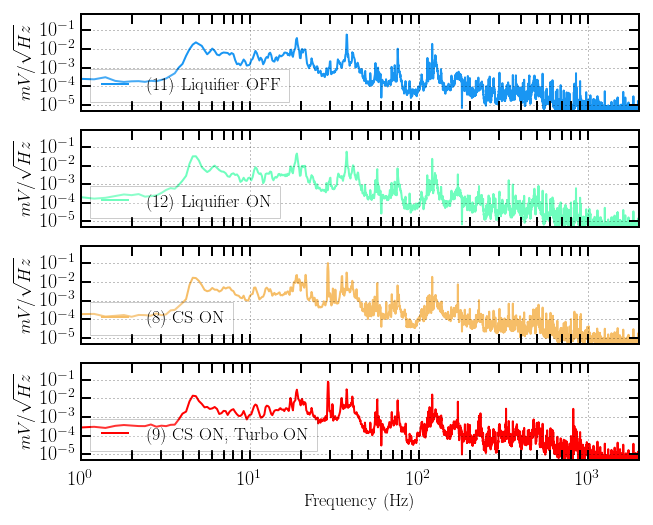

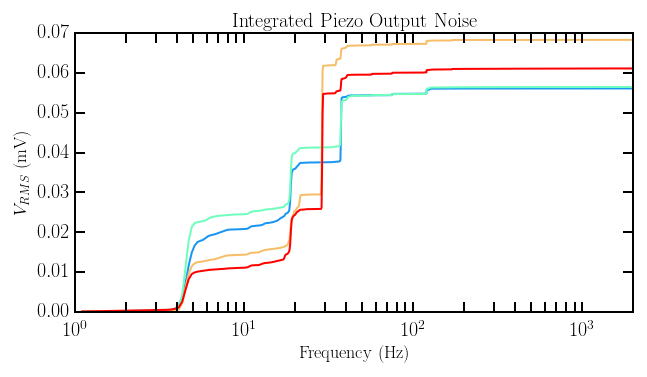

In [213]:
# plot ffts to compare as well as integrated noise

fs = 44100.0 # Hz
u_to_V = 0.0243 # mV
gain = 100
win = 5 # second

lows = []
mids = []
highs = []

samples = [11, 12, 8, 9]
N = len(samples)
lbs = [labels[s] for s in samples]
cs = plt.cm.rainbow(np.linspace(0.2,1,N))

fig, ax = plt.subplots(N,1, figsize=(10,2*N), sharex=True)
fig2, ax2 = plt.subplots(1,1, figsize=(10,5))

for n, i in enumerate(samples):
    # get data
    df_signal = wav_to_df(datasets[i], channel='right')
    xs, ffts = window_fft(df_signal['A_filt']*u_to_V/gain, win, overlap=0.5)
    signal_avg = np.mean(ffts, axis=0)
    
    # create plots of individual FFTs
    label = '({0:d}) {1}'.format(i, lbs[n])
    ax[n].plot(xs, signal_avg, color=cs[n], lw=2, label=label)
    ax[n].grid()
    ax[n].set_yscale('log')
    ax[n].set_ylim(5e-6, 0.8)
    ax[n].tick_params(axis='y',which='minor',left='off', right='off')
    ax[n].set_ylabel('$mV/\sqrt{Hz}$')
    ax[n].legend(loc='lower left', framealpha=0.2)
    
    # integrated noise plots
    ix, iv = all_integrated_noise(xs, signal_avg, 1, xs[-1])
    ax2.plot(ix, iv, color = cs[n], lw=2)
    
ax[-1].set_xscale('log')
ax[-1].set_xlim(1,2000)
ax[-1].set_xlabel('Frequency (Hz)')

ax2.set_xscale('log')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_xlim(1, 2000)
ax2.set_ylabel('$V_{RMS}$ (mV)')
ax2.set_title('Integrated Piezo Output Noise')

output = os.path.join(plot_dir,'piezo1/pumps-and-stuff_ffts.png')
fig.savefig(output, dpi=300)

output2 = os.path.join(plot_dir,'piezo1/pumps-and-stuff_integrated.png')
fig2.savefig(output2, dpi=300)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


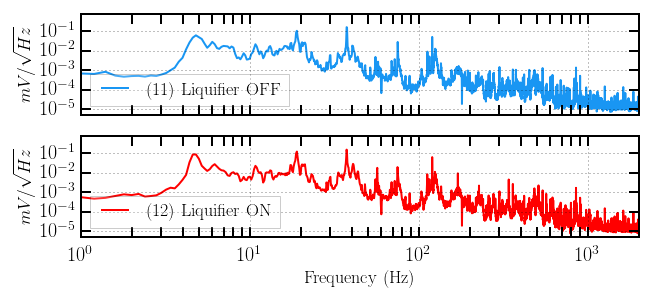

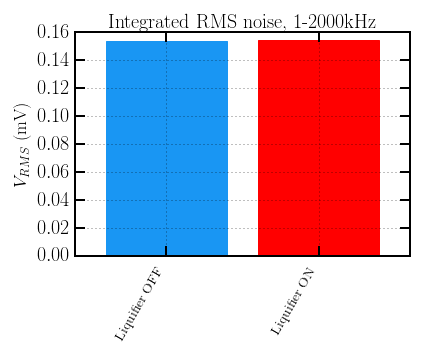

In [178]:
# compare ffts

fs = 44100.0 # Hz
u_to_V = 0.010 # mV
gain = 15
win = 5 # second

samples = [11, 12]
colors = plt.cm.rainbow(np.linspace(0.2,1,len(samples)))
rms = np.zeros(len(samples))
x = np.arange(0,len(samples))
lbs = [labels[s] for s in samples]

fig, ax = plt.subplots(len(samples),1, figsize=(10,2*len(samples)), sharex=True)

for n, i in enumerate(samples):
    df_signal = wav_to_df(datasets[i], channel='left')

    xs, ffts = window_fft(df_signal['A_filt']*u_to_V/gain, win, overlap=0.5)
    signal_avg = np.mean(ffts, axis=0)
    
    rms[n] = integrate_noise(xs, signal_avg, 1, 2000)

    label = '({0:d}) {1}'.format(i, lbs[n])
    ax[n].plot(xs, signal_avg, color=colors[n], lw=2, label=label)
    ax[n].grid()
    ax[n].set_yscale('log')
    ax[n].set_ylim(5e-6, 0.8)
    ax[n].tick_params(axis='y',which='minor',left='off', right='off')
    ax[n].set_ylabel('$mV/\sqrt{Hz}$')
    ax[n].legend(loc='lower left', framealpha=0.2)
    
ax[-1].set_xscale('log')
ax[-1].set_xlim(1,2000)
ax[-1].set_xlabel('Frequency (Hz)')

fig.savefig(os.path.join(plot_dir, 'piezo1/liquefier_compare.png'), dpi=300)

# plot total RMS noise for each measurement

fig, ax = plt.subplots(1,1, figsize = (6,4))

barlist=ax.bar(x, rms)
for j in range(len(barlist)):
    barlist[j].set_color(colors[j])
ax.set_xticks(x+0.4)
ax.set_xticklabels(lbs, rotation=60, ha='right', fontsize=14)
ax.set_xlim(-0.2,x[-1]+1)
ax.grid()
ax.set_ylabel('$V_{RMS}$ (mV)')
ax.set_title('Integrated RMS noise, 1-2000kHz')

fig.savefig(os.path.join(plot_dir, 'piezo1/liquefier_compare-rms.png'), dpi=300)

In [389]:
# fs = 44100.0 # Hz
# win = 1

# for i, f in enumerate(datasets):

#     # import data
#     df_signal = wav_to_df(f, channel='right')
#     xs, ffts = window_fft(df_signal['A_filt']/2.0**15, win, overlap=0.5)
#     xs = xs[1:]
#     ffts = ffts[:,1:]

#     # resample data with log10 scaling
#     dx = (xs[-1]-xs[0]) / (xs.size-1)
#     xnew = np.arange(np.log10(xs[1])+1, np.log10(xs[-1])+1, np.log10(dx)+1)
#     fft10 = np.zeros((len(ffts),len(xnew)))
#     for j in range(len(ffts)):
#         f = interpolate.interp1d(xs, ffts[j,:])
#         fft10[j,:] = f(xnew)

#     fft10avg = np.mean(fft10, axis=0)
#     xnew = _smooth(xnew, window_len=2001, window='hanning')
#     fft10avg = _smooth(fft10avg, window_len=2001, window='hanning')
#     peak_max, peak_min = peakdetect(np.log10(fft10avg), x_axis=xnew, lookahead=2000, delta=0.2)

#     fig, ax = plt.subplots(1,1, figsize=(10,5))
#     ax1 = ax.twinx() # use this to plot PSD behind peak colors

#     M = len(peak_max)
#     colors = plt.cm.rainbow(np.linspace(0,1,M))
#     for j in range(M):
#         ax1.vlines(x=peak_max[j,0], ymin=0, ymax=1.0, linewidths = 2, color=colors[j])

#     ax.plot(xnew, fft10avg, color='b')
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(xnew[0],xnew[-1])
    
#     ax.set_title('Mixing Chamber -- {0}'.format(labels[i]))
#     fig.tight_layout()
#     output = os.path.join(plot_dir, 'piezo1/Mixing-Chamber_{0}_peak-finding'.format(labels[i].replace(' ', '_')))
#     fig.savefig(output, dpi=300)
#     plt.close()

Make some plots of peak heights that represent different noise ranges... 4.2Hz, 140Hz, 8.2kHz

Maybe make some plots of integrated noise power in similar ranges... 0-20Hz, 200-2000Hz, 5000-10000Hz

# Piezo dataset 0

Dataset taken in air with the an old version of the piezo buffer circuit that had a gain of ~15. All values for mV and dBV are very approximate.

The piezo was held in place with double-sided tape and all measurements were done in air.

This dataset should really only be used for qualitative analysis to determine what noise frequencies originate from which piece of equipment.

In [234]:
os.chdir('/Users/nik/Dropbox/data_2016/vibration_testing/piezo_dataset_0/')

In [235]:
# Load wave files and save again with the left channel duplicated to the right so it is easier to listen to.

filelist = glob.glob('*.wav')

for f in filelist:
    sampFreq, snd = wavfile.read(f)
    snd[:,1] = snd[:,0]
    if f.endswith('_stereo.wav'):
        continue
    if not os.path.isfile(f[:-4]+'_stereo.wav'):
        wavfile.write(f[:-4]+'_stereo.wav', sampFreq, snd)

In [236]:
# metadata for this dataset

datasets = [('compressor_ptoff.wav', 'compressor_pton.wav'), 
            ('compressorlines_ptoff.wav', 'compressorlines_pton.wav'), 
            ('cryo4K_ptoff.wav', 'cryo4K_pton.wav'), 
            ('cryo50K_ptoff.wav', 'cryo50K_pton.wav'), 
            ('cryoBOB_ptoff.wav', 'cryoBOB_pton.wav'), 
            ('cryoCF_ptoff.wav', 'cryoCF_ptoff_son.wav'),
            ('cryoCF_ptoff.wav', 'cryoCF_pton.wav'),
            ('cryoFrame_high_ptoff.wav', 'cryoFrame_high_pton.wav'), 
            ('cryoFrame_low_ptoff.wav', 'cryoFrame_low_ptoff_son.wav'),
            ('cryoFrame_low_ptoff.wav', 'cryoFrame_low_pton.wav'), 
            ('cryoMC_ptoff.wav', 'cryoMC_pton.wav'), 
            ('cryoPTB_ptoff.wav', 'cryoPTB_pton.wav'), 
            ('cryostill_ptoff.wav', 'cryostill_pton.wav'), 
            ('cryotop_ptoff.wav', 'cryotop_pton.wav'), 
            ('DCrackCA_ptoff.wav', 'DCrackCA_pton.wav'), 
            ('ghc_toff_soff.wav', 'ghc_toff_son.wav'), 
            ('ghc_toff_soff.wav', 'ghc_ton_son.wav'),
            ('ghc_toff_soff.wav', 'ghc_ton_son_pton.wav'),
            ('isoplate_ptoff.wav', 'isoplate_pton.wav'), 
            ('RotValve_ptoff.wav', 'RotValve_pton.wav')]

onoff = ['PT', 
         'PT', 
         'PT', 
         'PT', 
         'PT', 
         'Scroll', 
         'PT', 
         'PT', 
         'Scroll', 
         'PT', 
         'PT', 
         'PT', 
         'PT', 
         'PT',
         'PT',
         'Scroll',
         'Turbo+Scroll',
         'Turbo+Scroll+PT',
         'PT', 
         'PT',]

locations = ['Compressor', 
             'Compressor Lines', 
             '4K plate', 
             '50K plate', 
             'Breakout Box', 
             'Cold Finger', 
             'Cold Finger', 
             'Frame (High)', 
             'Frame (Low)', 
             'Frame (Low)', 
             'Mixing Chamber', 
             'Pulse Tube Balast', 
             'Still', 
             '300K Plate', 
             'DC Rack (Current Amp)', 
             'Gas Handling Cabinet', 
             'Gas Handling Cabinet', 
             'Gas Handling Cabinet', 
             'Isolation Plate', 
             'Rotary Valve']

for i, names in enumerate(datasets):
    print(i, names, locations[i], onoff[i])

0 ('compressor_ptoff.wav', 'compressor_pton.wav') Compressor PT
1 ('compressorlines_ptoff.wav', 'compressorlines_pton.wav') Compressor Lines PT
2 ('cryo4K_ptoff.wav', 'cryo4K_pton.wav') 4K plate PT
3 ('cryo50K_ptoff.wav', 'cryo50K_pton.wav') 50K plate PT
4 ('cryoBOB_ptoff.wav', 'cryoBOB_pton.wav') Breakout Box PT
5 ('cryoCF_ptoff.wav', 'cryoCF_ptoff_son.wav') Cold Finger Scroll
6 ('cryoCF_ptoff.wav', 'cryoCF_pton.wav') Cold Finger PT
7 ('cryoFrame_high_ptoff.wav', 'cryoFrame_high_pton.wav') Frame (High) PT
8 ('cryoFrame_low_ptoff.wav', 'cryoFrame_low_ptoff_son.wav') Frame (Low) Scroll
9 ('cryoFrame_low_ptoff.wav', 'cryoFrame_low_pton.wav') Frame (Low) PT
10 ('cryoMC_ptoff.wav', 'cryoMC_pton.wav') Mixing Chamber PT
11 ('cryoPTB_ptoff.wav', 'cryoPTB_pton.wav') Pulse Tube Balast PT
12 ('cryostill_ptoff.wav', 'cryostill_pton.wav') Still PT
13 ('cryotop_ptoff.wav', 'cryotop_pton.wav') 300K Plate PT
14 ('DCrackCA_ptoff.wav', 'DCrackCA_pton.wav') DC Rack (Current Amp) PT
15 ('ghc_toff_soff.wa

In [94]:
# time trace + averaged FFT

fs = 44100.0 # Hz
u_to_V = 0.010 # mV
gain = 15
win = 1 # second

for i, f in enumerate(datasets):

    print(f)
    df_signal = wav_to_df(f[1], channel='left')
    df_background = wav_to_df(f[0], channel='left')

    fig, ax = plt.subplots(2,1, figsize=(10,6))

    t = df_signal['T']
    ax[0].plot(t, df_signal['A_filt']*u_to_V/gain*1000, color = 'blue', lw=2)
    ax[0].plot(t, df_background['A_filt']*u_to_V/gain*1000, color = 'silver', lw=2)
    ax[0].set_ylabel('Piezo Output ($\mu V$)')
    ax[0].set_xlabel('time (s)')
    ax[0].set_xlim(0,10)

    xs, ffts = window_fft(df_signal['A_filt']*u_to_V/gain, win, overlap=0.5)
    signal_avg = np.mean(ffts, axis=0)

    ax[1].plot(xs, signal_avg, color='blue', lw=2)
    ax[1].grid()
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(30,xs[-1])
    ax[1].set_ylim(1e-6, 1e-2)
    ax[1].tick_params(axis='y',which='minor',left='off', right='off')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('$mV/\sqrt{Hz}$')
    
    title = '({0:d}) {1} -- {2} ON/OFF'.format(i, locations[i], onoff[i])
    ax[0].set_title(title)
    
    output = os.path.join(plot_dir,'piezo0/{0}_{1}_single-fft'.format(locations[i].replace(' ', '_'), onoff[i]))
    fig.tight_layout()
#     print(output)
    fig.savefig(output, dpi=300)
    plt.close()

('compressor_ptoff.wav', 'compressor_pton.wav')
('compressorlines_ptoff.wav', 'compressorlines_pton.wav')
('cryo4K_ptoff.wav', 'cryo4K_pton.wav')
('cryo50K_ptoff.wav', 'cryo50K_pton.wav')
('cryoBOB_ptoff.wav', 'cryoBOB_pton.wav')
('cryoCF_ptoff.wav', 'cryoCF_ptoff_son.wav')
('cryoCF_ptoff.wav', 'cryoCF_pton.wav')
('cryoFrame_high_ptoff.wav', 'cryoFrame_high_pton.wav')
('cryoFrame_low_ptoff.wav', 'cryoFrame_low_ptoff_son.wav')
('cryoFrame_low_ptoff.wav', 'cryoFrame_low_pton.wav')
('cryoMC_ptoff.wav', 'cryoMC_pton.wav')
('cryoPTB_ptoff.wav', 'cryoPTB_pton.wav')
('cryostill_ptoff.wav', 'cryostill_pton.wav')
('cryotop_ptoff.wav', 'cryotop_pton.wav')
('DCrackCA_ptoff.wav', 'DCrackCA_pton.wav')
('ghc_toff_soff.wav', 'ghc_toff_son.wav')
('ghc_toff_soff.wav', 'ghc_ton_son.wav')
('ghc_toff_soff.wav', 'ghc_ton_son_pton.wav')
('isoplate_ptoff.wav', 'isoplate_pton.wav')
('RotValve_ptoff.wav', 'RotValve_pton.wav')


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [101]:
# plot FFTs as a function of time

fs = 44100.0 # Hz
u_to_V = 0.010 # mV
gain = 15
win = 0.04 # second

for i, names in enumerate(datasets):
    df = wav_to_df(names[1], channel='left')

    xs, ffts = window_fft(df['A_filt']*u_to_V/gain, win, overlap=0.5)
    ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
    dt = 1/fs
    n = ffts.shape[1]
    ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBV

    fig, ax = plt.subplots(1,1, figsize = (10,5))

    pc = ax.pcolormesh(xs, ys, ffts, cmap=plt.cm.Reds, vmin=-40, vmax=5)
    ax.set_xscale('log')
    ax.set_xlim(38, xs[-1])
    ax.set_ylim(20,20+2.8)
    ax.set_xlabel('f (Hz)')
    ax.set_ylabel('time (s)')
    # cb = fig.colorbar(pc)
    # cb.set_label('dBV')

    title = '({0:d}) {1} -- {2} ON'.format(i, locations[i], onoff[i])
    ax.set_title(title)
    
    output = os.path.join(plot_dir,'piezo0/{0}_{1}_time-fft'.format(locations[i].replace(' ', '_'), onoff[i]))
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


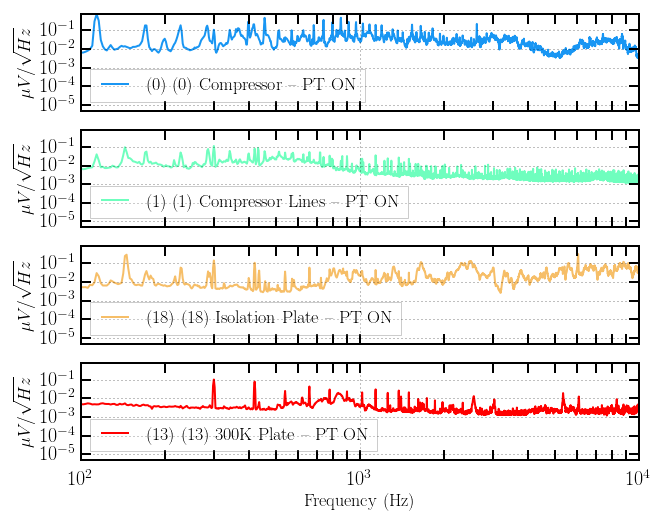

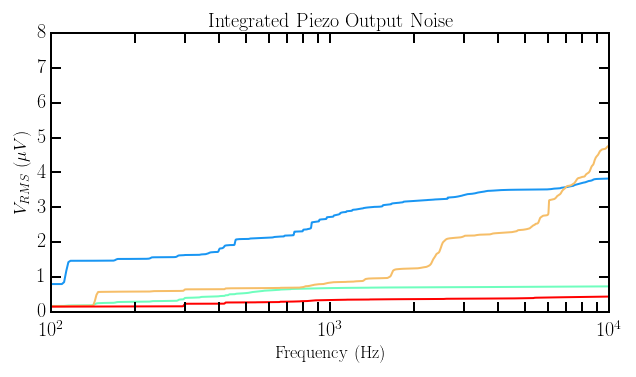

In [244]:
# plot ffts to compare as well as integrated noise

fs = 44100.0 # Hz
u_to_V = 0.0243*1000 # uV
gain = 100
win = 0.5 # second

samples = [0, 1, 18, 13]
N = len(samples)
lbs = ['({0:d}) {1} -- {2} ON'.format(s, locations[s], onoff[s]) for s in samples]
cs = plt.cm.rainbow(np.linspace(0.2,1,N))

fig, ax = plt.subplots(N,1, figsize=(10,2*N), sharex=True)
fig2, ax2 = plt.subplots(1,1, figsize=(10,5))

for n, i in enumerate(samples):
    # get data
    df_signal = wav_to_df(datasets[i][1], channel='left')
    xs, ffts = window_fft(df_signal['A_filt']*u_to_V/gain, win, overlap=0.5)
    signal_avg = np.mean(ffts, axis=0)
    
    # create plots of individual FFTs
    label = '({0:d}) {1}'.format(i, lbs[n])
    ax[n].plot(xs, signal_avg, color=cs[n], lw=2, label=label)
    ax[n].grid()
    ax[n].set_yscale('log')
    ax[n].set_ylim(5e-6, 0.8)
    ax[n].tick_params(axis='y',which='minor',left='off', right='off')
    ax[n].set_ylabel('$\mu V/\sqrt{Hz}$')
    ax[n].legend(loc='lower left', framealpha=0.2)
    
    # integrated noise plots
    ix, iv = all_integrated_noise(xs, signal_avg, 1, xs[-1])
    ax2.plot(ix, iv, color = cs[n], lw=2)
    
ax[-1].set_xscale('log')
ax[-1].set_xlim(100,10000)
ax[-1].set_xlabel('Frequency (Hz)')

ax2.set_xscale('log')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_xlim(100, 10000)
ax2.set_ylabel('$V_{RMS}$ ($\mu V$)')
ax2.set_title('Integrated Piezo Output Noise')

output = os.path.join(plot_dir,'piezo0/compressor0_ffts.png')
fig.savefig(output, dpi=300)

output2 = os.path.join(plot_dir,'piezo0/compressor0_integrated.png')
fig2.savefig(output2, dpi=300)

# SET Noise (Soundcard)

Taken from Mohammad's Al SET sample on GaAs at 10mK and 1.6T.

All of these are current noise measurements.

    Gain = 1e-9 A/V
    AC bias = 5uV

In [308]:
os.chdir('/Users/nik/Dropbox/data_2016/vibration_testing/SET_Noise/')

In [309]:
# Load wave files and save again with the left channel duplicated to the right so it is easier to listen to.

filelist = glob.glob('*.wav')

for f in filelist:
    sampFreq, snd = wavfile.read(f)
    snd[:,0] = snd[:,1]
    if f.endswith('_stereo.wav'):
        continue
    if not os.path.isfile(f[:-4]+'_stereo.wav'):
        wavfile.write(f[:-4]+'_stereo.wav', sampFreq, snd)

In [310]:
for f in glob.glob('*_stereo.wav'):
    print('\'{0}\''.format(f))

'PTOFF_LIAOFF_stereo.wav'
'PTON_LIAOFF_stereo.wav'
'PTON_LIAON_stereo.wav'
'PTON_LIAON_sweep-gate_2_stereo.wav'
'PTON_LIAON_sweep-gate_stereo.wav'


In [313]:
f = 'PTOFF_LIAOFF_stereo.wav'
sampFreq, snd = wavfile.read(f)
wavfile.write('set_PTOFF.wav', sampFreq, snd[176400:529200])
wavfile.write('set_PTON.wav', sampFreq, snd[882000:1234800])
wavfile.write('set_PTOFF-PTON.wav', sampFreq, snd[176400:1234800])

In [250]:
datasets = ['PTOFF_LIAOFF_stereo.wav',
            'PTON_LIAOFF_stereo.wav',
            'PTON_LIAON_stereo.wav',
            'PTON_LIAON_sweep-gate_stereo.wav',
            'PTON_LIAON_sweep-gate_2_stereo.wav']
            
resistance = ['2MOhm', '2MOhm', '2MOhm', 'variable', 'variable']

labels = ['PT OFF-BIAS OFF',
          'PT ON-BIAS OFF',
          'PT ON-BIAS ON',
          'Gate Sweep 72',
          'Gate Sweep 73']

for i, names in enumerate(datasets):
    print(i, names, labels[i])

0 PTOFF_LIAOFF_stereo.wav PT OFF-BIAS OFF
1 PTON_LIAOFF_stereo.wav PT ON-BIAS OFF
2 PTON_LIAON_stereo.wav PT ON-BIAS ON
3 PTON_LIAON_sweep-gate_stereo.wav Gate Sweep 72
4 PTON_LIAON_sweep-gate_2_stereo.wav Gate Sweep 73


In [311]:
882000+529200-176400

1234800

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


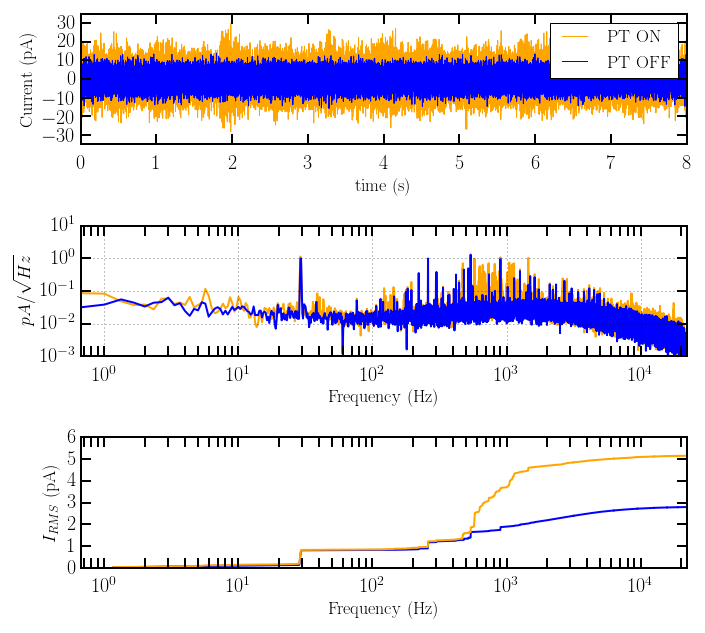

In [225]:
# pulse tube noise

fs = 44100.0 # Hz
u_to_V = 0.0243e-3 # V
gain = 1000 # pA/V

df = wav_to_df(datasets[0], channel='right')
ptoff = df.iloc[176400:529200]
ptoff['T'] = ptoff['T']-ptoff.iloc[0,2]
pton = df.iloc[882000:882000+len(ptoff)]
pton['T'] = pton['T']-pton.iloc[0,2]

fig, ax = plt.subplots(3,1, figsize=(10,9))

t = ptoff['T']
ax[0].plot(t, pton['A_filt']*u_to_V*gain, color = 'orange', label='PT ON', lw=1)
ax[0].plot(t, ptoff['A_filt']*u_to_V*gain, color = 'blue', label='PT OFF', lw=1)

ax[0].set_ylabel('Current (pA)')
ax[0].set_xlabel('time (s)')
ax[0].set_xlim(0,8)
ax[0].set_ylim(-35,35)
ax[0].legend(loc='upper right')

win = 3
xs, ffts = window_fft(pton['A_filt']*u_to_V*gain, win, overlap=0.5)
pton_avg = np.mean(ffts, axis=0)
ax[1].plot(xs, pton_avg, color='orange', lw=2)

xs, ffts = window_fft(ptoff['A_filt']*u_to_V*gain, win, overlap=0.5)
ptoff_avg = np.mean(ffts, axis=0)
ax[1].plot(xs, ptoff_avg, color='blue', lw=2)

ax[1].tick_params(axis='y',which='minor',left='off', right='off')
ax[1].grid()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(xs[2],xs[-1])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('$pA/\sqrt{Hz}$')
ax[1].set_ylim(0.001, 10)

ibx, ibn = all_integrated_noise(xs, ptoff_avg, 1, xs[-1])
isx, isn = all_integrated_noise(xs, pton_avg, 1, xs[-1])
ax[2].plot(ibx, ibn, lw=2, color = 'blue')
ax[2].plot(isx, isn, lw=2, color='orange')
ax[2].set_xscale('log')
ax[2].set_xlim(xs[2],xs[-1])
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('$I_{RMS}$ (pA)')

fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'SET/full_spectrum.png'), dpi=300)

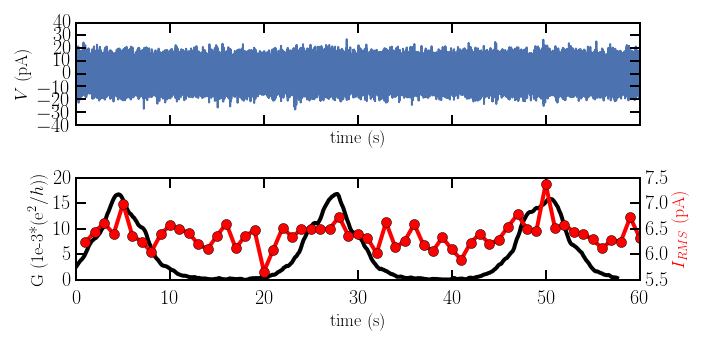

In [30]:
# gate sweep
fs = 44100.0 # Hz
u_to_V = 0.0243e-3 # V
gain = 1000 # pA/V

g2x = np.loadtxt('dat72g2x.csv', delimiter=',')
df = wav_to_df(datasets[3], channel='right', filter_signal=True)
df['A_filt'] = df['A_filt']*u_to_V*gain

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex = True)

ax[0].plot(df['T'], df['A_filt'], lw=2)
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('$V$ (pA)')
ax[0].set_xlim(0,60)
ax[0].set_ylim(-40,40)

ax[1].plot(g2x[:,0]/10.0-2.4, (g2x[:,1]*1e-9)/(5e-6)/(3.874e-5)*1000, color='k')
# ax[1].set_xlabel('SET Gate (mV)')
ax[1].set_ylabel('G (1e-3*(e^2/h))', color='k')
ax[1].set_ylim(0,20)

ax1 = ax[1].twinx()

x, rms = window_rms(df, 2.0, window='hanning', overlap=0.5)
ax1.plot(x, rms, 'o-', ms = 10, color='r')
ax1.set_ylabel('$I_{RMS}$ (pA)', color='red')
ax1.set_ylim(5.5,7.5)
ax[1].set_xlabel('time (s)')
ax[1].set_xlim(0,60)

fig.tight_layout()

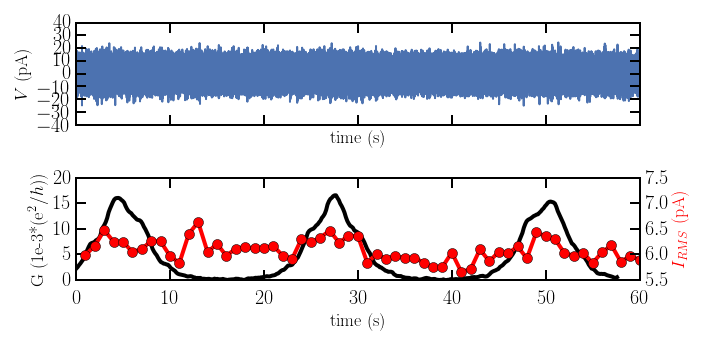

In [31]:
# gate sweep
fs = 44100.0 # Hz
u_to_V = 0.0243e-3 # V
gain = 1000 # pA/V

g2x = np.loadtxt('dat73g2x.csv', delimiter=',')
df = wav_to_df(datasets[4], channel='right', filter_signal=True)
df['A_filt'] = df['A_filt']*u_to_V*gain

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex = True)

ax[0].plot(df['T'], df['A_filt'], lw=2)
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('$V$ (pA)')
ax[0].set_xlim(0,60)
ax[0].set_ylim(-40,40)

ax[1].plot(g2x[:,0]/10.0-2.4, (g2x[:,1]*1e-9)/(5e-6)/(3.874e-5)*1000, color='k')
# ax[1].set_xlabel('SET Gate (mV)')
ax[1].set_ylabel('G (1e-3*(e^2/h))', color='k')
ax[1].set_ylim(0,20)

ax1 = ax[1].twinx()

x, rms = window_rms(df, 2.0, window='hanning', overlap=0.5)
ax1.plot(x, rms, 'o-', ms = 10, color='r')
ax1.set_ylabel('$I_{RMS}$ (pA)', color='red')
ax1.set_ylim(5.5,7.5)
ax[1].set_xlabel('time (s)')
ax[1].set_xlim(0,60)

fig.tight_layout()

In [333]:
f = 'PTON_LIAOFF_stereo.wav'

# save bandpass audio
sampFreq, snd = wavfile.read(f)
filtered =  bandpass_filter(snd[:,1], 300, 2000, fs=44100.0)
snd[:,0] = filtered
snd[:,1] = filtered
wavfile.write('set_PTON_BIASOFF_bandpass.wav', sampFreq, snd)

(1323008,)
(1323008,)


In [329]:
filtered

NameError: name 'filtered' is not defined

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:166: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


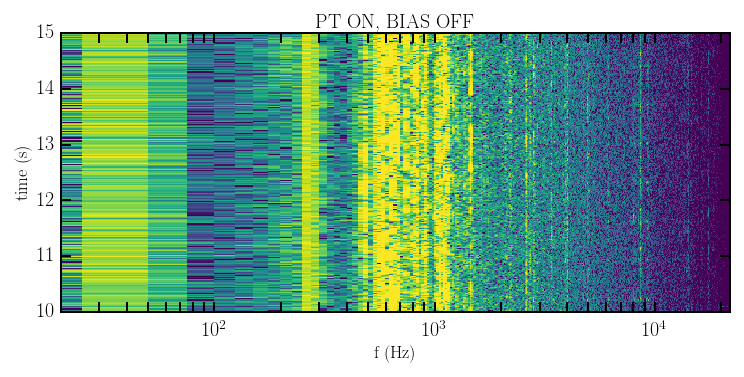

In [327]:
# plot PT ON, BIAS OFF

fs = 44100.0 # Hz
u_to_V = 0.0243e-3 # V
gain = 1000 # pA/V
win = 0.04

f = 'PTON_LIAOFF_stereo.wav'
limits = [(10,15)]
ls = ['PT ON-BIAS OFF']

filter_signal=False
df = wav_to_df(f, channel='right', filter_signal=filter_signal)

xs, ffts = window_fft((df['A_filt']*u_to_V)*gain, win, overlap=0.5)
ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
dt = 1/fs
n = ffts.shape[1]
ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBpA

fig, ax = plt.subplots(1,1, figsize = (12,5))

pc = ax.pcolormesh(xs, ys, ffts, cmap=plt.cm.viridis, vmin=30, vmax=60)
ax.set_xscale('log')
ax.set_xlim(20, xs[-1])
ax.set_ylim(limits[i])
ax.set_xlabel('f (Hz)')
ax.set_ylabel('time (s)')
ax.set_title('PT ON, BIAS OFF')

output = os.path.join(plot_dir, 'set/PT_ON_BIAS_OFF.png')
fig.savefig(output, dpi=300)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


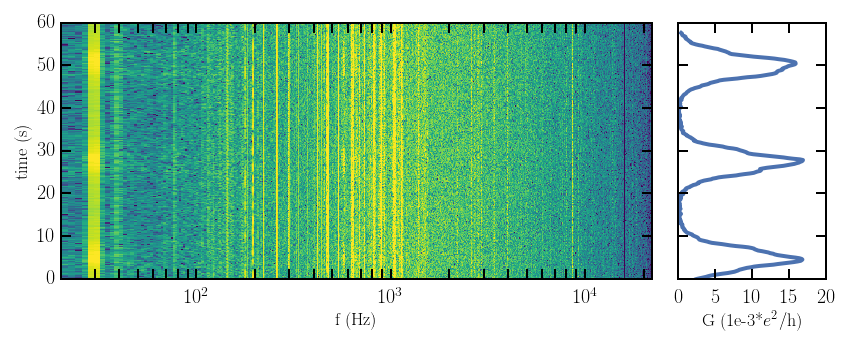

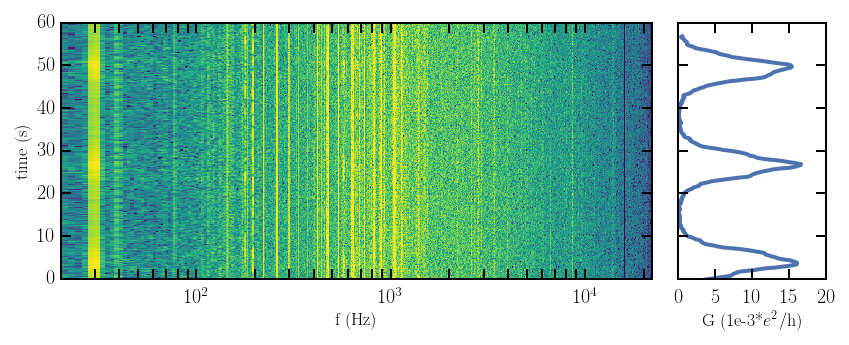

In [54]:
# plot ffts alongside the conductance trace

fs = 44100.0 # Hz
u_to_V = 0.0243e-3 # V
gain = 1000 # pA/V
win = 0.5

filenames = [datasets[3], datasets[4]]
conductance = ['dat72g2x.csv', 'dat73g2x.csv']
offsets = [2.4, 3.2]
limits = [(0,60), (0,60)]
titles = [r'Sweep Gate (1)', r'Sweep Gate (2)']
ls = ['Sweep Gate 72', 'Sweep Gate 73']

for i, f in enumerate(filenames):
    filter_signal=True
    df = wav_to_df(f, channel='right', filter_signal=filter_signal)

    xs, ffts = window_fft((df['A_filt']*u_to_V)*gain, win, overlap=0.5)
    ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
    dt = 1/fs
    n = ffts.shape[1]
    ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBpA

    g2x = np.loadtxt(conductance[i], delimiter=',')
    
    fig = plt.figure(figsize=(12,5))
    gs = gridspec.GridSpec(1,2, width_ratios=[4, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    pc = ax1.pcolormesh(xs, ys, ffts, cmap=plt.cm.viridis, vmin=20, vmax=70)
    ax1.set_xscale('log')
    ax1.set_xlim(20, xs[-1])
    ax1.set_ylim(limits[i])
    ax1.set_xlabel('f (Hz)')
    ax1.set_ylabel('time (s)')
    
    ax2.plot((g2x[:,1]*1e-9)/(5e-6)/(3.874e-5)*1000, g2x[:,0]/10.0-offsets[i])
    ax2.set_ylim(limits[i])
    ax2.set_yticklabels([])
    ax2.set_xlabel('G (1e-3*$e^2$/h)')
    ax2.set_xlim(0,20)

    ax.set_title('{0}'.format(titles[i]))
    fig.tight_layout()
    output = os.path.join(plot_dir, 'set/{0}_time-slow-fft.png'.format(titles[i].replace(' ', '_')))
    fig.savefig(output, dpi=300)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 384


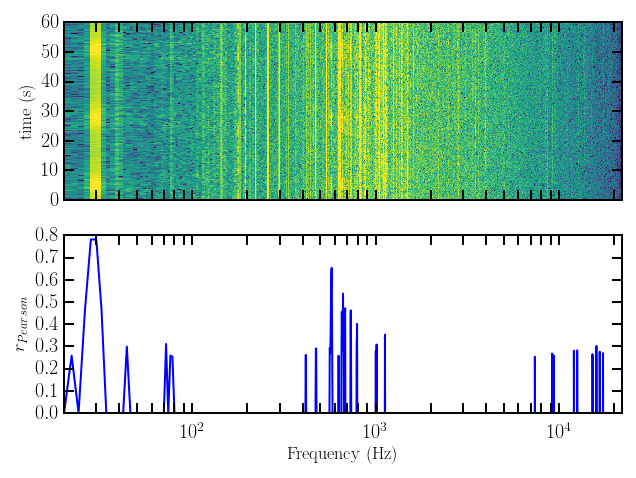

In [302]:
# gate sweep 1

fs = 44100.0 # Hz
u_to_V = 0.0243e-3 # V
gain = 1000 # pA/V
win = 0.5

f = datasets[3]
c = 'dat72g2x.csv'
g2x = np.loadtxt(c, delimiter=',')
gy = (g2x[:,1]*1e-9)/(5e-6)/(3.874e-5)*1000 # 1e-3*e^2/h
gx = (g2x[:,0]/10.0)-2.4 # time, seconds
df = wav_to_df(f, channel='right', filter_signal=True)

xs, ffts = window_fft((df['A_filt']*u_to_V)*gain, win, overlap=0.5) # use the unfiltered data
ffts_copy = ffts
ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
dt = 1/fs
n = ffts.shape[1]
ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBpA

fig, ax = plt.subplots(2,1, figsize=(10,7), sharex=True)

pc = ax[0].pcolormesh(xs, ys, ffts, cmap=plt.cm.viridis, vmin=20, vmax=70)
ax[0].set_ylim(0,60)
ax[0].set_ylabel('time (s)')

r = np.zeros(len(xs))
p = np.zeros(len(xs))
gx = gx[gx>0]
gy = gy[gx>0]
for i, column in enumerate(ffts.T):
    func = interpolate.interp1d(ys, column)
    new_column = func(gx)
    r[i], p[i] = stats.pearsonr(gy, new_column)
# only plot where abs(r)>0.3 and p<0.05
correlated = (r>0.25) & (p<0.05)
uncorrelated = np.invert(correlated)
r[uncorrelated] = 0.0
p[uncorrelated] = 0.0
ax[1].plot(xs, r, lw=2, color='blue')
# ax[1].plot(xs, p, lw=2, color='red')
ax[1].set_xscale('log')
ax[1].set_xlim(20, xs[-1])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('$r_{Pearson}$')

# fig.savefig(os.path.join(plot_dir, 'set/dat72_noise_pearsonr.png'))

Total integrated current noise = 1.7762450665689349pA
2780620.15099
Total integrated voltage noise = 4.939062825204689$\mu V$


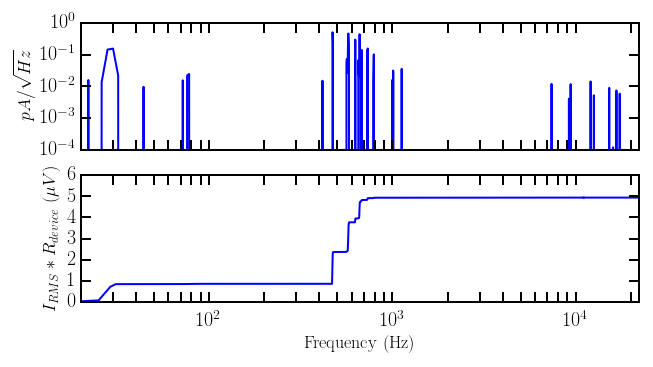

In [307]:
# use the above calculation to add up the voltage noise across the sample
# take just the frequencies that are correlated with the conductance and add those

x = xs
y = ys
ffts = ffts_copy
R = ((5e-6)/(g2x[:,1]*1e-9))
t = gx

it = np.abs(t-5.0).argmin()
R_5 = R[it]

iy = np.abs(y-5.0).argmin()
s = ffts[iy,:]
s[uncorrelated] = 0

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True)

ax[0].plot(x, s, lw=2, color='blue')
ax[0].set_yscale('log')
ax[0].set_ylabel('$pA/\sqrt{Hz}$')
ax[0].tick_params(axis='y',which='minor',left='off', right='off')

isx, isn = all_integrated_noise(x, s, 1, xs[-1])
ax[1].plot(isx, isn*R_5*1e6*1e-12, lw=2, color='blue')
ax[1].set_xscale('log')
ax[1].set_xlim(20,xs[-1])
ax[1].set_ylim(0,6.0)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('$I_{RMS}*R_{device}$ ($\mu V$)')

print('Total integrated current noise = {0}pA'.format(isn.max()))
print(R_5)
print(r'Total integrated voltage noise = {0}$\mu V$'.format(isn.max()*1e-12*R_5*1e6))

fig.savefig(os.path.join(plot_dir, 'set/correlated_voltage_noise.png'), dpi=300)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 383


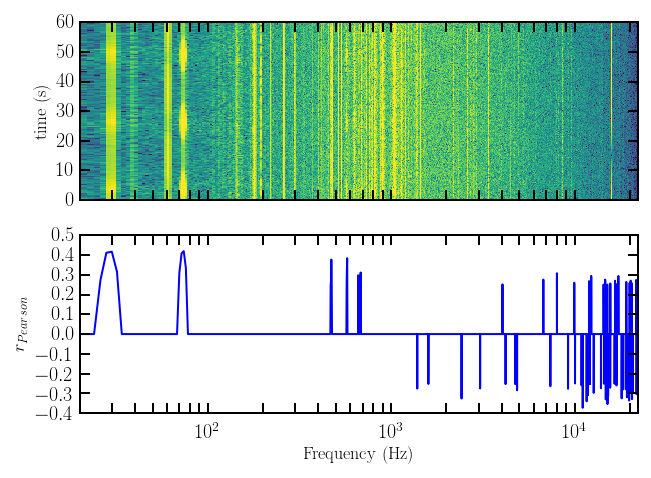

In [283]:
# gate sweep 2

fs = 44100.0 # Hz
u_to_V = 0.0243e-3 # V
gain = 1000 # pA/V
win = 0.5

f = datasets[4]
c = 'dat73g2x.csv'
g2x = np.loadtxt(c, delimiter=',')
gy = (g2x[:,1]*1e-9)/(5e-6)/(3.874e-5)*1000 # 1e-3*e^2/h
gx = (g2x[:,0]/10.0)-2.5 # time, seconds
df = wav_to_df(f, channel='right', filter_signal=True)

xs, ffts = window_fft((df['A']*u_to_V)*gain, win, overlap=0.5) # use the unfiltered data
ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
dt = 1/fs
n = ffts.shape[1]
ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBpA

fig, ax = plt.subplots(2,1, figsize=(10,7), sharex=True)

pc = ax[0].pcolormesh(xs, ys, ffts, cmap=plt.cm.viridis, vmin=20, vmax=70)
ax[0].set_ylim(0,60)
ax[0].set_ylabel('time (s)')

r = np.zeros(len(xs))
p = np.zeros(len(xs))
gx = gx[gx>0]
gy = gy[gx>0]
for i, column in enumerate(ffts.T):
    func = interpolate.interp1d(ys, column)
    new_column = func(gx)
    r[i], p[i] = stats.pearsonr(gy, new_column)
# only plot where abs(r)>0.3 and p<0.05
correlated = (np.abs(r)>0.25) & (p<0.05)
uncorrelated = np.invert(correlated)
r[uncorrelated] = 0.0
p[uncorrelated] = 0.0
ax[1].plot(xs, r, lw=2, color='blue')
# ax[1].plot(xs, p, lw=2, color='red')
ax[1].set_xscale('log')
ax[1].set_xlim(20, xs[-1])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('$r_{Pearson}$')

The low frequency noise (mostly from the scroll pump vibrations) produces ~0.4uV RMS voltage noise. Between 100 and 1000Hz there is about 1.0uV RMS voltage noise. At high frequencies, there is no sign that the noise goes through the sample.

In total, there is roughly 1.4uV of noise across the sample, coming from the pulse tube and gas handling cabinet. That corresponds to 15-20mK. With some sound proofing and moving equipment around, it looks like that could easily be reduced by a factor of 2 or 3; where it would no longer contribute signficantly to the device temperature.

In [66]:
# plot FFTs as a function of time

fs = 44100.0 # Hz
u_to_V = 0.0243e-3 # V
gain = 1000 # pA/V
win = 0.04 #s

for i, f in enumerate(datasets):
    df = wav_to_df(f, channel='right', filter_signal=True)

    xs, ffts = window_fft(df['A_filt']*u_to_V*gain, win, overlap=0.5)
    ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
    dt = 1/fs
    n = ffts.shape[1]
    ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBV

    fig, ax = plt.subplots(1,1, figsize = (10,5))

    pc = ax.pcolormesh(xs, ys, ffts, cmap=plt.cm.viridis, vmin=30, vmax=60)
    ax.set_xscale('log')
    ax.set_xlim(20, xs[-1])
    ax.set_ylim(15,15+2.8)
    ax.set_xlabel('f (Hz)')
    ax.set_ylabel('time (s)')
#     cb = fig.colorbar(pc)
#     cb.set_label('dBpA')

    title = '({0:d}) {1}'.format(i, labels[i])
    ax.set_title(title)
    
    output = os.path.join(plot_dir,'SET/{0}_time-fft'.format(labels[i].replace(' ', '_')))
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:153: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
